In [1]:
# !pip install torchsummary
!pip install split-folders

In [2]:
!nvidia-smi

Sun Apr  7 02:03:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              28W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import splitfolders
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from google.colab import drive

from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [8]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
DATASET_DIR = "/content/drive/MyDrive/AAI_Dataset/PlantVillage"

In [ ]:
# # Extracting the zip dataset
# import zipfile
# import os

# # Path to the zip file in Google Drive
# zip_file_path = f"{DATASET_DIR}/color.zip"

# # Destination folder to extract the zip file
# extracted_folder_path = f"{DATASET_DIR}/"

# # Check if the destination folder exists, if not, create it
# if not os.path.exists(extracted_folder_path):
#     os.makedirs(extracted_folder_path)

# # Extract the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_folder_path)

# # List the contents of the extracted folder
# extracted_files = os.listdir(extracted_folder_path)
# print("Files extracted successfully:")
# print(extracted_files)

Files extracted successfully:
['color.zip', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)']


In [6]:
#Split folder into train, test and validation set.
splitfolders.ratio('/content/drive/MyDrive/AAI_Dataset/PlantVillage/', output="/content/drive/MyDrive/AAI_Dataset/PlantVillage/", seed=1337, ratio=(.8, .1, .1))

Copying files: 3000 files [01:10, 42.73 files/s]


In [11]:
train_dir = DATASET_DIR + "/train"
valid_dir = DATASET_DIR + "/val"
test_dir = DATASET_DIR + "/test"
diseases = os.listdir(train_dir)

# Print diseases name
print(diseases)

['Apple___Cedar_apple_rust', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Pepper,_bell___Bacterial_spot', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Spider_mites Two-spotted_spider_mite']


In [8]:
print(f"Total classes are: {len(diseases)}")

Total classes are: 15


In [12]:
# Count the number of unique plants and disease
plants = set()
conditions = set()

number_of_diseases = 0

for plant in diseases:
    plant_name, condition = plant.split('___')
    conditions.add(condition)
    plant_name = plant_name.replace('_', ' ').replace(', ', ' ').title()
    plants.add(plant_name)
    if condition != 'healthy':
        number_of_diseases += 1

plants = list(plants)
conditions =list(conditions)

In [13]:
# Unique plants
print(f"Number of unique plants are: \n{plants}")

Number of unique plants are: 
['Pepper Bell', 'Soybean', 'Tomato', 'Corn (Maize)', 'Squash', 'Potato', 'Cherry (Including Sour)', 'Apple', 'Raspberry', 'Strawberry', 'Orange', 'Peach', 'Grape']


In [14]:
# Unique plants count
print(f"Number of unique plants: {len(plants)}")

Number of unique plants: 13


In [15]:
# Unique unique disease count
print(f"Number of unique disease: {number_of_diseases}")
print(conditions)

Number of unique disease: 13
['Cedar_apple_rust', 'Leaf_blight_(Isariopsis_Leaf_Spot)', 'Leaf_scorch', 'Bacterial_spot', 'Haunglongbing_(Citrus_greening)', 'Spider_mites Two-spotted_spider_mite', 'Northern_Leaf_Blight', 'Tomato_mosaic_virus', 'Late_blight', 'Septoria_leaf_spot', 'healthy', 'Powdery_mildew']


In [16]:
nums = {disease: len(os.listdir(os.path.join(train_dir, disease))) for disease in diseases}

# Converting the nums dictionary to pandas DataFrame with plant name as index and number of images as column
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of images"])

img_per_class

No. of images
Apple___Cedar_apple_rust                                 160
Cherry_(including_sour)___Powdery_mildew                 160
Corn_(maize)___Northern_Leaf_Blight                      160
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)               160
Orange___Haunglongbing_(Citrus_greening)                 160
Peach___Bacterial_spot                                   160
Pepper,_bell___Bacterial_spot                            160
Potato___Late_blight                                     160
Raspberry___healthy                                      160
Soybean___healthy                                        160
Squash___Powdery_mildew                                  160
Strawberry___Leaf_scorch                                 160
Tomato___Septoria_leaf_spot                              160
Tomato___Tomato_mosaic_virus                             160
Tomato___Spider_mites Two-spotted_spider_mite            160

In [17]:
import torchvision
import torchvision.transforms as transforms

def get_image_transforms():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image_data_transforms = {
    'training': get_image_transforms(),
    'validation': get_image_transforms(),
    'testing': get_image_transforms()
}





batch_size = 32
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=image_data_transforms['training'])
val_dataset = torchvision.datasets.ImageFolder(valid_dir, transform=image_data_transforms['validation'])
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=image_data_transforms['testing'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)



<ipython-input-18-fb203da1fe06>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=img_per_class, x=img_per_class.index, palette="viridis")


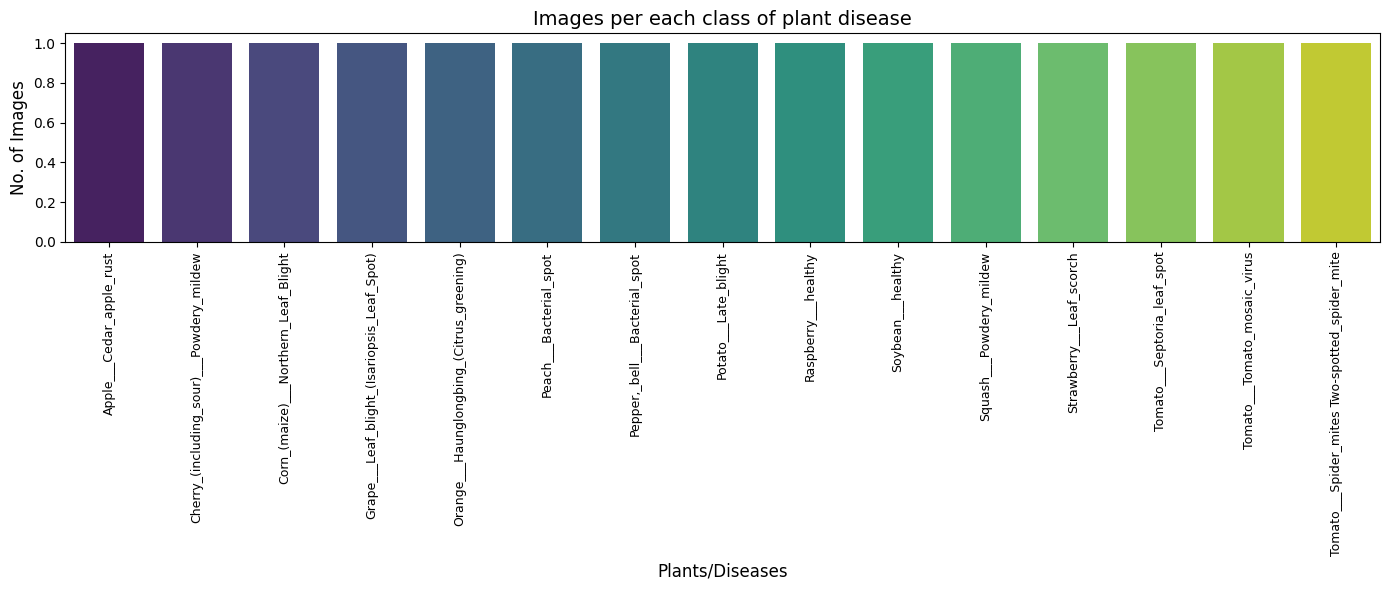

In [18]:
plt.figure(figsize=(14, 6))
sns.countplot(data=img_per_class, x=img_per_class.index, palette="viridis")
plt.xlabel('Plants/Diseases', fontsize=12)
plt.ylabel('No. of Images', fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.title('Images per each class of plant disease', fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = models.vgg19(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Dropout(0.7),  # Increased dropout rate
#     nn.Linear(num_ftrs, len(train_dataset.classes))
# )
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(num_ftrs, 15)
)
model.to(device)


Device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

Device: cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

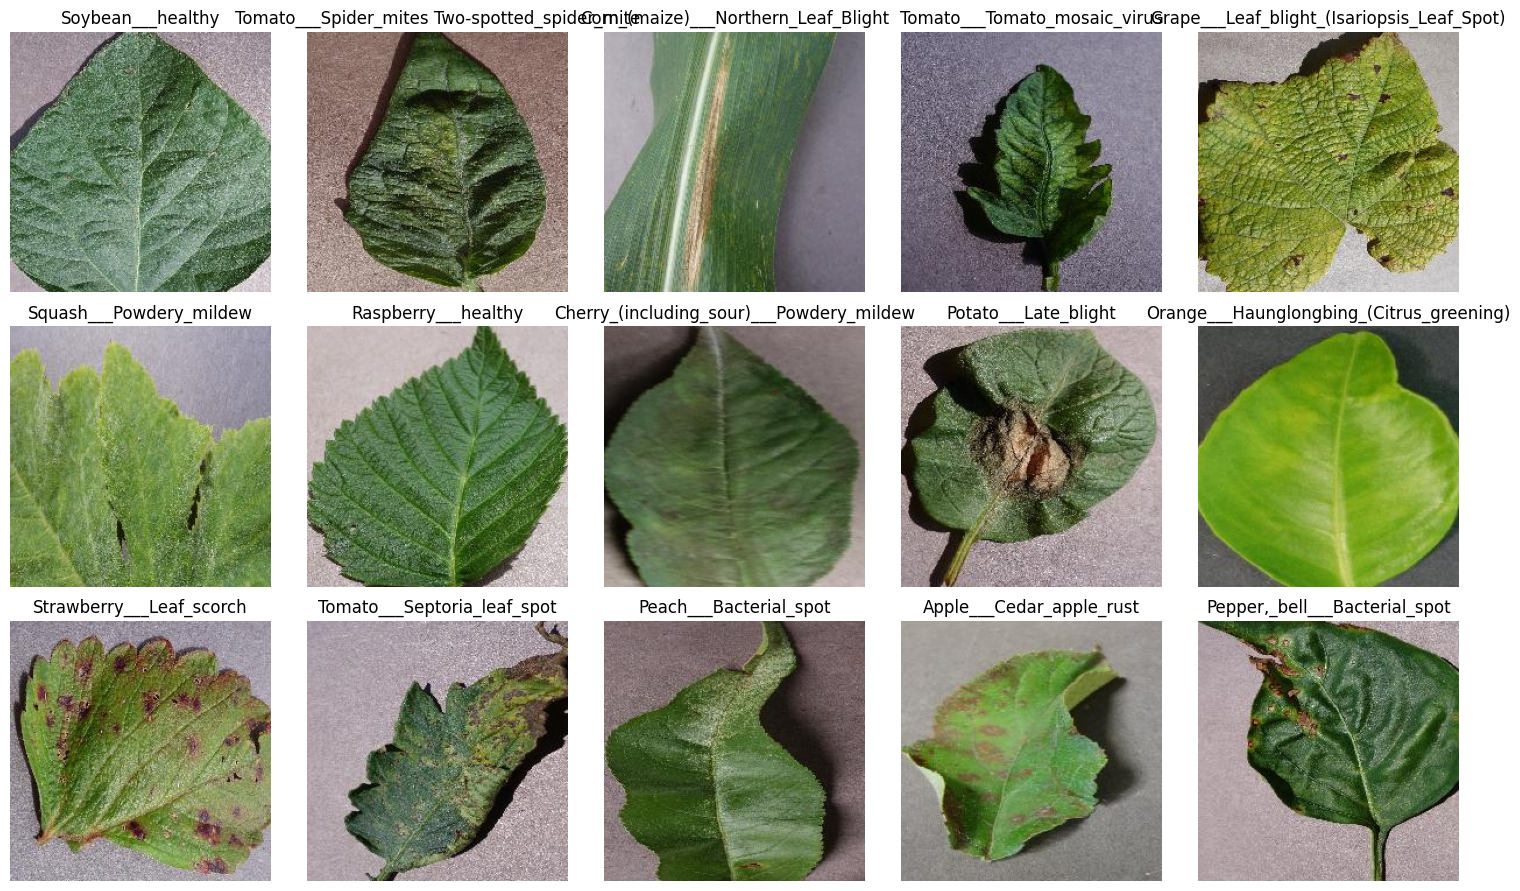

In [21]:
unique_classes = set()
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

num_classes = len(class_to_idx)
num_rows = math.ceil(num_classes/5)
num_cols = min(5, num_classes)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

row_index = 0
col_index = 0

for images, labels in train_loader:
    for image, label in zip(images, labels):
        class_name = idx_to_class[label.item()]
        if class_name not in unique_classes:
            unique_classes.add(class_name)
            ax = axes[row_index, col_index]
            img = image.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')

            col_index += 1
            if col_index == num_cols:
                col_index = 0
                row_index += 1

        if len(unique_classes) == num_classes:
            break
    if len(unique_classes) == num_classes:
        break

plt.tight_layout()
plt.show()

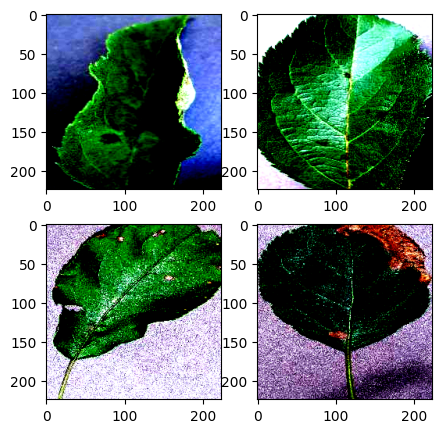

In [22]:
class_names = {
    0: 'Apple___Cedar_apple_rust',
    1: 'Cherry_(including_sour)___Powdery_mildew',
    2: 'Corn_(maize)___Northern_Leaf_Blight',
    3: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    4: 'Orange___Haunglongbing_(Citrus_greening)',
    5: 'Peach___Bacterial_spot',
    6: 'Pepper,_bell___Bacterial_spot',
    7: 'Potato___Late_blight',
    8: 'Raspberry___healthy',
    9: 'Soybean___healthy',
    10: 'Squash___Powdery_mildew',
    11: 'Strawberry___Leaf_scorch',
    12: 'Tomato___Septoria_leaf_spot',
    13: 'Tomato___Tomato_mosaic_virus',
    14: 'Tomato___Spider_mites Two-spotted_spider_mite'
}



In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)


In [24]:
torch.cuda.is_available()

True

In [25]:
print(32 * len(train_loader))

2400


SyntaxError: invalid syntax (<ipython-input-21-6c1ce8338235>, line 1)

In [26]:
import torch.nn as nn

# finallayer of neural network model
final_layer = None

# Iterate over the layers of the model to find the final layer
for layer in model.modules():
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        final_layer = layer

# Print the number of output units in the final layer
if final_layer is not None:
    num_output_units = final_layer.out_features
    print("nodes in the output layer of a neural network:", num_output_units)
else:
    print("Layer not found, recheck the architecure")


nodes in the output layer of a neural network: 15


In [27]:
import pandas as pd
from torch.utils.tensorboard import SummaryWriter

In [28]:
# Define the path for TensorBoard summary
TENSORBOARD_SUMMARY_PATH = f'{DATASET_DIR}/Vgg19_PlantVillage'
writer = SummaryWriter(TENSORBOARD_SUMMARY_PATH)

In [29]:
BEST_MODEL_PATH='/content/drive/MyDrive/AAI_Dataset/PlantVillage/Vgg19_PlantVillage/events.out.tfevents.1710950765.d30585750db7.911.0'

In [30]:
num_epochs = 10
dataframe = pd.DataFrame({
    "Epoch": pd.Series(dtype="int"),
    "train_loss": pd.Series(dtype="float"),
    "train_accuracy": pd.Series(dtype="float"),
    "val_loss": pd.Series(dtype="float"),
    "val_accuracy": pd.Series(dtype="float")
})

import time

# Define the total number of training iterations
total_iterations = num_epochs * len(train_loader)

# Start time
start_time = time.time()

for epoch in range(num_epochs):
    # Train mode
    model.train()
    train_loss = 0
    train_correct = 0

    for i, (feature, target) in enumerate(train_loader):
        feature, target = feature.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(feature)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * feature.shape[0]
        train_correct += (output.argmax(1) == target).sum().item()

        # Clear GPU memory
        del feature, target, output
        torch.cuda.empty_cache()

        # Calculate current iteration progress
        current_iteration = epoch * len(train_loader) + i + 1
        progress_percentage = (current_iteration / total_iterations) * 100

        # Print progress
        #print(f'Progress: {current_iteration}/{total_iterations} [{progress_percentage:.2f}%]')

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    # Validation mode
    model.eval()
    val_loss = 0
    val_correct = 0

    with torch.no_grad():
        for feature, target in val_loader:
            feature, target = feature.to(device), target.to(device)
            output = model(feature)
            loss = criterion(output, target)
            val_loss += loss.item() * feature.shape[0]
            val_correct += (output.argmax(1) == target).sum().item()

            # Clear GPU memory
            del feature, target, output
            torch.cuda.empty_cache()

    val_loss /= len(val_dataset)
    val_accuracy = val_correct / len(val_dataset)

    # Print results for this epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'
          .format(epoch+1, num_epochs, train_loss, train_accuracy*100, val_loss, val_accuracy*100))
    dataframe.loc[len(dataframe.index)] = [epoch+1, train_loss, train_accuracy, val_loss, val_accuracy]

    # Add training and validation metrics to TensorBoard
    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('train_accuracy', train_accuracy, epoch)
    writer.add_scalar('val_loss', val_loss, epoch)
    writer.add_scalar('val_accuracy', val_accuracy, epoch)

# End time
end_time = time.time()

# Calculate total training time
training_time = end_time - start_time
print(f'Total training time: {training_time:.2f} seconds')


Epoch [1/10], Train Loss: 2.6030, Train Acc: 14.33%, Val Loss: 2.0750, Val Acc: 64.33%
Epoch [2/10], Train Loss: 1.8489, Train Acc: 40.62%, Val Loss: 0.9359, Val Acc: 84.67%
Epoch [3/10], Train Loss: 1.0411, Train Acc: 67.50%, Val Loss: 0.3385, Val Acc: 93.67%
Epoch [4/10], Train Loss: 0.6314, Train Acc: 78.71%, Val Loss: 0.1724, Val Acc: 96.00%
Epoch [5/10], Train Loss: 0.4394, Train Acc: 86.04%, Val Loss: 0.1226, Val Acc: 96.33%
Epoch [6/10], Train Loss: 0.2737, Train Acc: 91.54%, Val Loss: 0.1074, Val Acc: 96.00%
Epoch [7/10], Train Loss: 0.2350, Train Acc: 92.46%, Val Loss: 0.1103, Val Acc: 96.67%
Epoch [8/10], Train Loss: 0.1639, Train Acc: 94.92%, Val Loss: 0.0944, Val Acc: 96.33%
Epoch [9/10], Train Loss: 0.1467, Train Acc: 95.33%, Val Loss: 0.0819, Val Acc: 97.33%
Epoch [10/10], Train Loss: 0.1219, Train Acc: 96.00%, Val Loss: 0.0736, Val Acc: 97.67%
Total training time: 148.95 seconds


In [31]:
dataframe.head(10)

Epoch  train_loss  train_accuracy  val_loss  val_accuracy
0    1.0    2.603048        0.143333  2.074991      0.643333
1    2.0    1.848867        0.406250  0.935905      0.846667
2    3.0    1.041140        0.675000  0.338463      0.936667
3    4.0    0.631418        0.787083  0.172419      0.960000
4    5.0    0.439352        0.860417  0.122599      0.963333
5    6.0    0.273749        0.915417  0.107386      0.960000
6    7.0    0.235022        0.924583  0.110339      0.966667
7    8.0    0.163929        0.949167  0.094383      0.963333
8    9.0    0.146721        0.953333  0.081865      0.973333
9   10.0    0.121910        0.960000  0.073589      0.976667

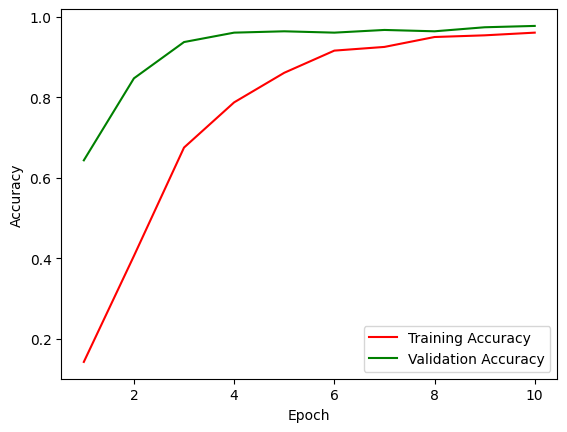

In [32]:
import matplotlib.pyplot as plt

def plot_accuracy(df, train_col, val_col, train_label, val_label):
    plt.plot(df.Epoch, df[train_col], 'r', label=train_label)
    plt.plot(df.Epoch, df[val_col], 'g', label=val_label)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# Callng the function with train,test,val arguments
plot_accuracy(dataframe, 'train_accuracy', 'val_accuracy', 'Training Accuracy', 'Validation Accuracy')




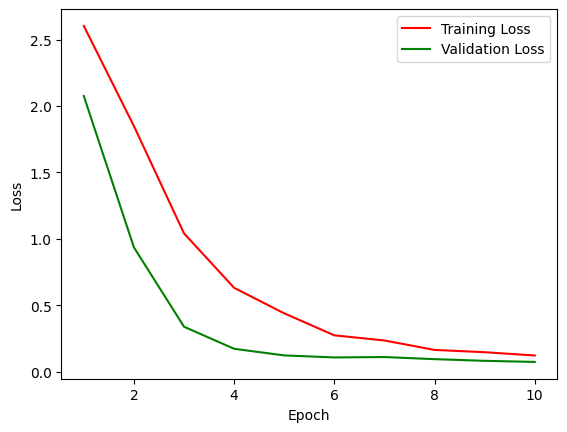

In [33]:

import matplotlib.pyplot as plt

def plot_loss(df, train_col, val_col, train_label, val_label):
    plt.plot(df.Epoch, df[train_col], 'r', label=train_label)
    plt.plot(df.Epoch, df[val_col], 'g', label=val_label)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Call the function with appropriate arguments
plot_loss(dataframe, 'train_loss', 'val_loss', 'Training Loss', 'Validation Loss')


In [34]:
model.eval()  # set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test accuracy: %d %%' % (100 * correct / total))

Test accuracy: 99 %


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


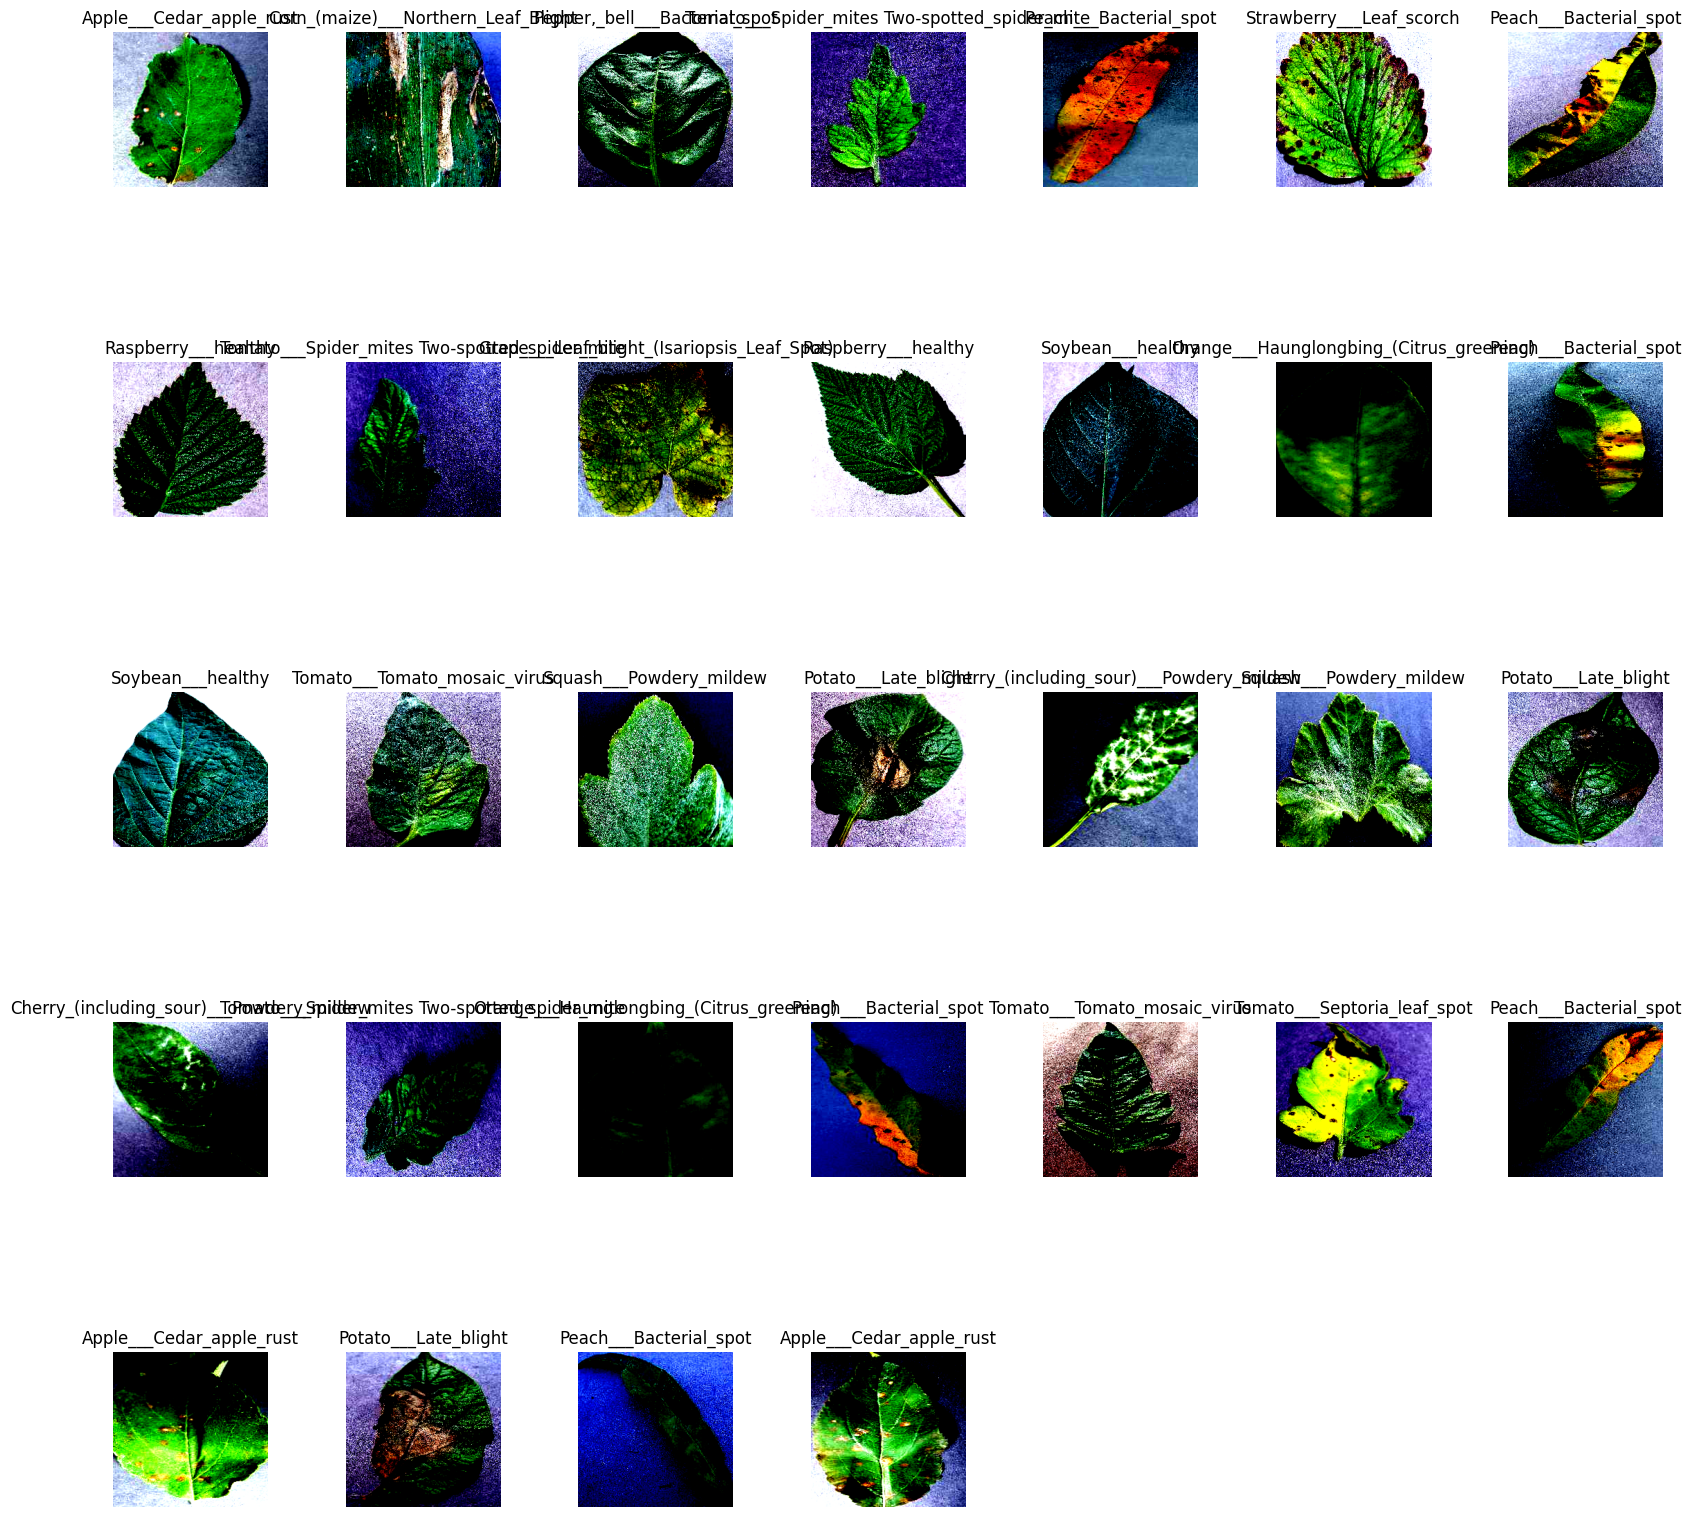

In [35]:

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')
# get the train dataset batches
inputs, classes = next(iter(train_loader))
inputs = inputs.numpy()


# Determine the number of images
num_images = inputs.shape[0]

# Determine the number of rows and columns for subplot arrangement
num_rows = int(np.sqrt(num_images))
num_cols = int(np.ceil(num_images / num_rows))

# Create a figure
fig = plt.figure(figsize=(20, 20))

# Plot the images
for i in range(32):  # Plot the first 32 images
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(inputs[i].transpose((1, 2, 0)))  # Transpose the dimensions to match the expected format
    plt.title(f'{class_names[classes[i].item()]}')  # Set the title with the class name
    plt.axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Increase the vertical and horizontal spacing

# Show the plot
plt.show()


# Save the figure
fig.savefig('/content/drive/My Drive/AAI_Dataset/PlantVillageVggResultsSaving/allDiseaseImages.png')



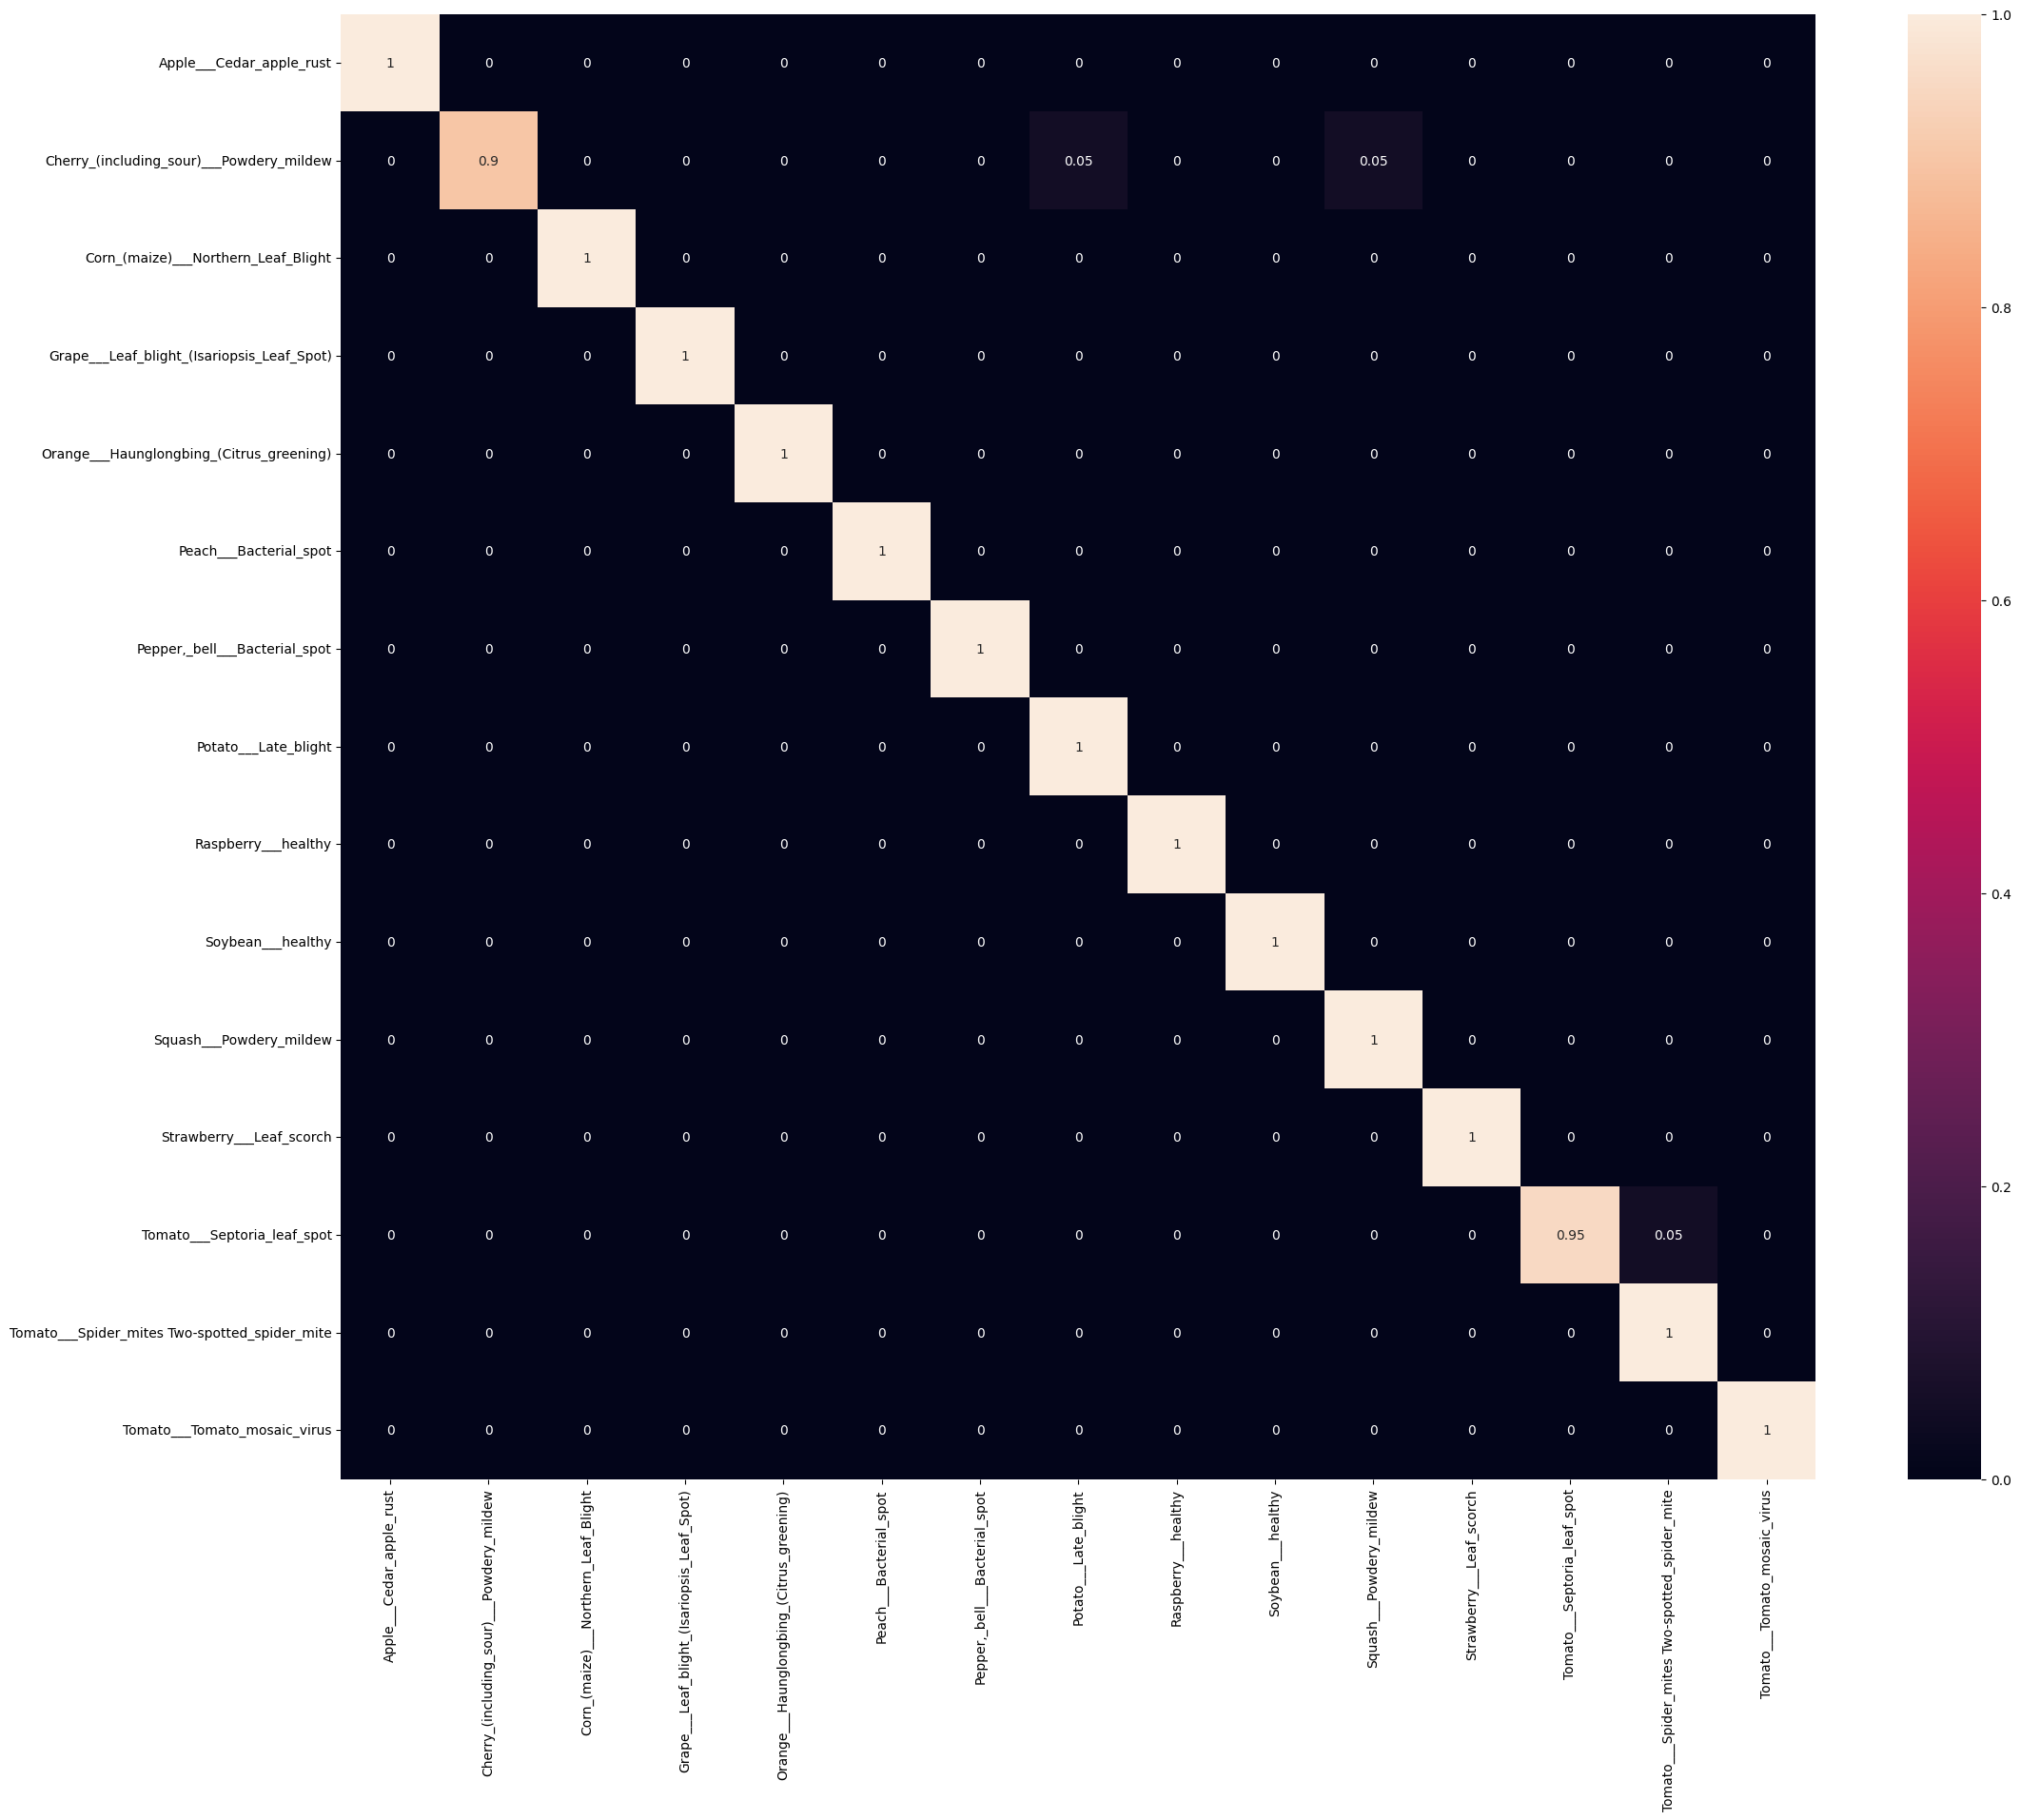

In [36]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def get_predictions(model, test_loader):
    y_true = []
    y_pred = []

    # iterate over test data
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)  # Feed Network

        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())  # Save Prediction
        y_true.extend(labels.cpu().numpy())  # Save Truth

    return y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    # Building confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
    df_cm = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=(25, 20))
    sns.heatmap(df_cm, annot=True)
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Get predictions
y_true, y_pred = get_predictions(model, test_loader)

# Define constant for classes
class_names = test_dataset.classes

# Plot and save confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names, save_path='/content/drive/My Drive/AAI_Dataset/PlantVillageVggResultsSaving/confusionMatrixVgg.png')









In [37]:
torch.save(model, "/content/drive/My Drive/AAI_Dataset/PlantVillageVggResultsSaving/vgg19result.pth")

In [38]:
dataframe.to_csv("/content/drive/My Drive/AAI_Dataset/PlantVillageVggResultsSaving/csv_vgg19_results",index=False)

In [39]:
dataframe.head()

Epoch  train_loss  train_accuracy  val_loss  val_accuracy
0    1.0    2.603048        0.143333  2.074991      0.643333
1    2.0    1.848867        0.406250  0.935905      0.846667
2    3.0    1.041140        0.675000  0.338463      0.936667
3    4.0    0.631418        0.787083  0.172419      0.960000
4    5.0    0.439352        0.860417  0.122599      0.963333

In [40]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, classification_report



print(classification_report(y_true, y_pred,target_names=test_dataset.classes))

print("Overall accuracy==> {:.2f}".format(accuracy_score(y_true=y_true, y_pred=y_pred)))

                                               precision    recall  f1-score   support

                     Apple___Cedar_apple_rust       1.00      1.00      1.00        20
     Cherry_(including_sour)___Powdery_mildew       1.00      0.90      0.95        20
          Corn_(maize)___Northern_Leaf_Blight       1.00      1.00      1.00        20
   Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      1.00      1.00        20
     Orange___Haunglongbing_(Citrus_greening)       1.00      1.00      1.00        20
                       Peach___Bacterial_spot       1.00      1.00      1.00        20
                Pepper,_bell___Bacterial_spot       1.00      1.00      1.00        20
                         Potato___Late_blight       0.95      1.00      0.98        20
                          Raspberry___healthy       1.00      1.00      1.00        20
                            Soybean___healthy       1.00      1.00      1.00        20
                      Squash___Powdery_mil

In [46]:
def extract_features(loader, model, device):
    features = []
    targets = []
    model.eval()
    outputs = None
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return np.array(features), np.array(targets)

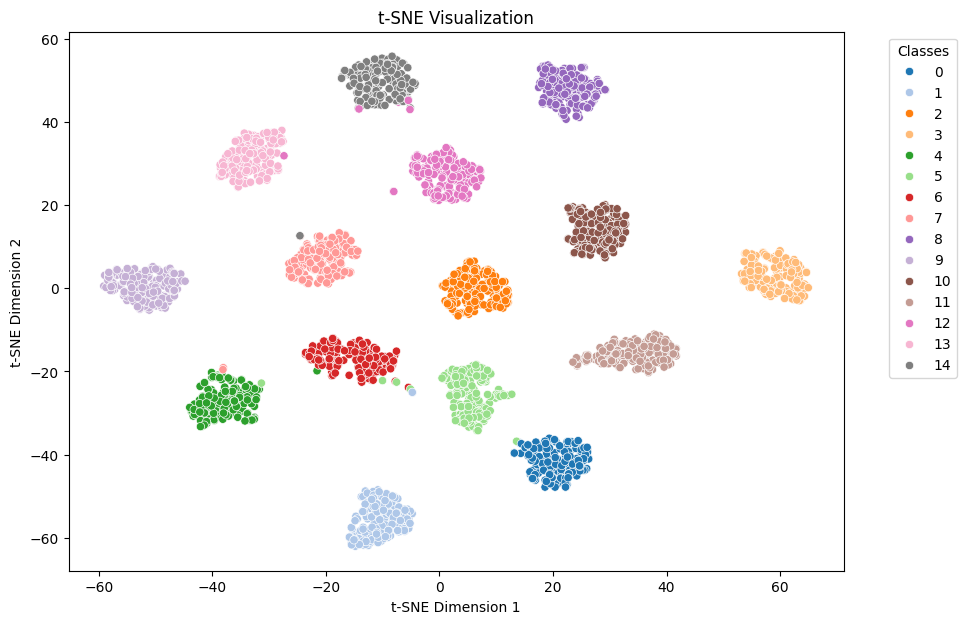

In [47]:
train_features, train_targets = extract_features(train_loader, model, device)
val_features, val_targets = extract_features(val_loader, model, device)

all_features = np.concatenate((train_features, val_features), axis=0)
all_targets = np.concatenate((train_targets, val_targets), axis=0)

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(all_features)


plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=all_targets, palette='tab20', legend='full')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()